In [2]:
# Colab specific setup
try:
  from google.colab import drive
  
except Exception:
  # Local setup
  rootpath = "."

else:
  drive.mount('/content/drive')
  rootpath = '/content/drive/My Drive/6.869/pytorch-vqa-abs'

Mounted at /content/drive


In [3]:
import torch
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")
    print("You may want to try to use the GPU in Google Colab by clicking in:")
    print("Runtime > Change Runtime type > Hardware accelerator > GPU.")

Using the GPU!


In [4]:
!nvidia-smi

Sat Apr 30 02:19:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!pwd
import os 
os.chdir(rootpath)
!pwd

/content
/content/drive/.shortcut-targets-by-id/1Ar7h59qYql2V1BVT_KCUpOwxAJ37yRsc/6.869/pytorch-vqa-abs


#### Process the images 
Use Restnet18 to compute the high level representation of the input image. The last layer of Resnet18 before the final pooling layer is used.

In [ ]:
!python3 preprocess-images.py

not valid id 000000011220 (1).png
not valid id 000000015046 (1).png
not valid id 000000001033 (1).png
found 8611 images in ../image_dataset_abs/train2015
found 2000 images in ../image_dataset_abs/val2015
100% 166/166 [17:33<00:00,  6.35s/it]


#### Process the questions and answers.  

In [ ]:
!python3 preprocess-vocab.py


### Train the model

In [ ]:
!python3 train.py

will save to logs/2022-04-22_04:18:44.pth
/content/drive/.shortcut-targets-by-id/1Ar7h59qYql2V1BVT_KCUpOwxAJ37yRsc/6.869/pytorch-vqa-abs/model.py:127: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(self.embedding.weight)
/content/drive/.shortcut-targets-by-id/1Ar7h59qYql2V1BVT_KCUpOwxAJ37yRsc/6.869/pytorch-vqa-abs/model.py:84: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(m.weight)
train E000: 100% 807/807 [00:34<00:00, 23.64it/s, acc=0.2914, loss=3.0563]
val E000: 100% 188/188 [00:08<00:00, 22.77it/s, acc=0.3716, loss=2.8428]
train E001: 100% 807/807 [00:35<00:00, 22.91it/s, acc=0.3544, loss=2.9900]
val E001: 100% 188/188 [00:07<00:00, 25.78it/s, acc=0.3949, loss=2.7014]
train E002: 100% 807/807 [00:34<00:00, 23.65it/s, acc=0.4332, loss=2.9351]
val E002: 100% 188/188 [00:07<00:00, 26.39it/s, acc=0.3988, loss=2.6449]
train E003: 100% 807/807 [00:32<00:00,

#### plot training process

In [ ]:
!python view-log.py 'logs/2022-04-22_04:18:44.pth'

(-0.5, 639.5, 479.5, -0.5)

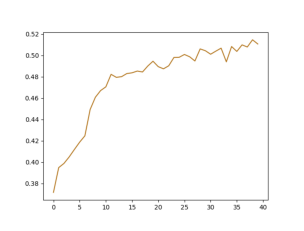

In [ ]:
import matplotlib.pyplot as plt
import cv2
acc_plot = cv2.imread('val_acc.png')
plt.imshow(acc_plot)
plt.axis('off')

## Result & Visualization

### Retrieve the model 

In [6]:
import torch
import model

log = torch.load('logs/2022-04-22_02:43:55.pth') #strong base 2022-04-22_02/43/55.pth
tokens = len(log['vocab']['question']) + 1

net = torch.nn.DataParallel(model.Net(tokens)).to(device) # Net: strong base / Net0: shallow base
net.load_state_dict(log['weights'])

/content/drive/.shortcut-targets-by-id/1Ar7h59qYql2V1BVT_KCUpOwxAJ37yRsc/6.869/pytorch-vqa-abs/model.py:140: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(self.embedding.weight)
/content/drive/.shortcut-targets-by-id/1Ar7h59qYql2V1BVT_KCUpOwxAJ37yRsc/6.869/pytorch-vqa-abs/model.py:44: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(m.weight)


<All keys matched successfully>

#### Question and answer encoding 

In [24]:
import utils
import json
import data
questions_path = utils.path_for(train=False, val=True, test=False, question=True)
answers_path = utils.path_for(train=False, val=True, test=False, answer=True)
with open(questions_path, 'r') as fd:
    questions_json = json.load(fd)
with open(answers_path, 'r') as fd:
    answers_json = json.load(fd)
with open(config.vocabulary_path, 'r') as fd:
    vocab_json = json.load(fd)

# vocab
token_to_index = vocab_json['question']
answer_to_index = vocab_json['answer']
index_to_token = dict([(ind, tok) for tok, ind in answer_to_index.items()])

def encode_question(question):
    """ Turn a question into a vector of indices and a question length """
    vec = torch.zeros(max_question_len).long()
    for i, token in enumerate(question):
        index = token_to_index.get(token, 0)
        vec[i] = index
    return vec, len(question)

def encode_answers(answers):
    """ Turn an answer into a vector """
    # answer vec will be a vector of answer counts to determine which answers will contribute to the loss.
    # this should be multiplied with 0.1 * negative log-likelihoods that a model produces and then summed up
    # to get the loss that is weighted by how many humans gave that answer
    answer_vec = torch.zeros(len(answer_to_index))
    for answer in answers:
        index = answer_to_index.get(answer)
        if index is not None:
            answer_vec[index] += 1
    return answer_vec

# q and a
questions = list(data.prepare_questions(questions_json))
answers = list(data.prepare_answers(answers_json))
max_question_len = max(map(len, questions))

questions_encoded = [encode_question(q) for q in questions]
answers_encoded = [encode_answers(a) for a in answers]


In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import config
import os
import h5py
import data
import utils

## load validation data
transform = utils.get_transform(config.image_size, config.central_fraction)
val_dataset = data.CocoImages(config.val_path, transform=None) 

## load image features
features_file = h5py.File(config.preprocessed_path, 'r')
coco_ids = features_file['ids'][()]
coco_id_to_index = {id: i for i, id in enumerate(coco_ids)}

def load_image(image_id):
    """ Load an image """
    index = coco_id_to_index[image_id]
    dataset = features_file['features']
    img = dataset[index].astype('float32')
    return torch.from_numpy(img)


## Output module 
def out_result(image_item, question_item):
    # select the image 
    item_list = list(val_dataset.id_to_filename.keys())
    item_id = item_list[image_item]
    item_file = val_dataset.id_to_filename[item_id]
    item_img = Image.open(os.path.join(config.val_path, item_file)).convert('RGB')

    # find the corresponding questions 
    question_match = [q for q in questions_json['questions'] if q['image_id'] == item_id]
    answer_match = [a for a in answers_json['annotations'] if a['image_id'] == item_id]
    question_position = [i for i in range(len(questions_json['questions'])) if questions_json['questions'][i]['image_id'] == item_id]
    print('question {} of the image {}\n {} \n'.format(question_item, item_id, question_match[question_item]['question']))

    # feed to the model 
    v = load_image(item_id)
    q, q_len = questions_encoded[question_position[question_item]]
    a = answers_encoded[question_position[question_item]]

    v = torch.unsqueeze(v,0).to(device)
    q = torch.unsqueeze(q,0).to(device)
    q_len = torch.unsqueeze(torch.tensor(q_len),0).to(device)
    out = net(v, q, q_len)

    out_prob, out_ind = out.data.cpu().softmax(dim=-1).topk(3)
    out_prob = out_prob.view(-1).numpy()
    out_ind = out_ind.view(-1).numpy()
    out_ans = [index_to_token[x] for x in out_ind]

    # visualization 
    fig, axs = plt.subplots(1,1,figsize=(10,10))
    axs.imshow(item_img)

    print([answer_match[question_item]['answers'][i]['answer'] for i in range(10)])
    print('Top three output {} and probability {}'.format(out_ans, out_prob))









found 2000 images in ../image_dataset_abs/val2015


question 2 of the image 24838
 Is there clouds in the sky? 

['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes']
Top three output ['yes', 'no', 'bird'] and probability [0.7443512  0.19812316 0.00958392]


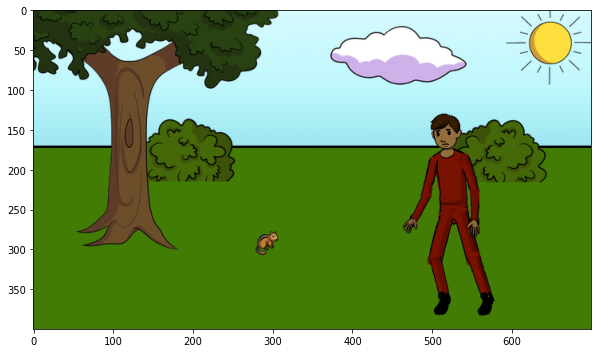

In [43]:
image_item = 70
question_item = 2
out_result(image_item, question_item)

question 2 of the image 29108
 What color are the monkey bars? 

['blue', 'blue', 'blue', 'black', 'blue', 'blue', 'blue', 'blue', 'blue', 'dark blue']
Top three output ['blue', 'black', 'dark blue'] and probability [0.7871896  0.1751999  0.02593273]


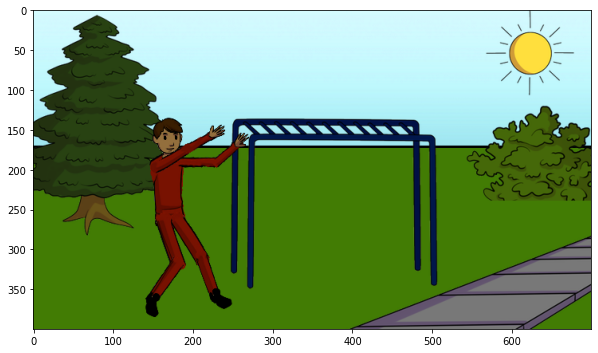

In [30]:
image_item = 4
question_item = 2
out_result(image_item, question_item)

### Investigate on the caption

In [32]:
import json
with open('./vqa/captions_abstract_v002_train2015.json') as fd:
    caption_train = json.load(fd)
caption_train['annotations'][:3]

[{'caption': 'A woman is sitting in the park having a picnic.',
  'id': 47250,
  'image_id': 4725},
 {'caption': 'A girl sitting on a log in the sun eating spare ribs.',
  'id': 47251,
  'image_id': 4725},
 {'caption': 'A bright sunny day with a girl on a log and a watermelon on a blanket.',
  'id': 47252,
  'image_id': 4725}]

### Visualization of the attention 

In [62]:
import torch.nn as nn
import model


class Net_attention(nn.Module):
    def __init__(self, net):
        super(Net_attention, self).__init__()
        self.model = net

        def save_output(module, input, output):
            self.buffer = output
        self.model.module.attention.register_forward_hook(save_output)

    def forward(self, v,q,q_len):
        self.model(v,q,q_len)
        return self.buffer


## Featuremap visualization
def visualize_featuremap(im_input, feature_maps, filter_id, alpha=0.4, beta = 0.7):
    feature_map = feature_maps.squeeze(0)[filter_id]
    # Normalize to [0..1], with a little leeway (0.9999) in case feature_map has 0 range
    feature_map = feature_map / (feature_map.max() + 1e-10)
    # Convert to numpy (detach() just seperates a tensor from the gradient)
    feat_numpy = feature_map.cpu().numpy()
    # Resize the feature map to our original image size (our strided conv layers reduce the size of the image)
    feat_numpy = cv2.resize(feat_numpy, (im_input.shape[1], im_input.shape[0]))
    # Invert to make the heatmap look more natural
    map_t = 1 - feat_numpy
    # Add an extra dimension to make this a [H,W,C=1] image
    feat_numpy = np.expand_dims(feat_numpy, axis=2)

    # Convert to image (UINT8 from 0-255)
    map_t = 255 * map_t
    map_t = map_t.astype(np.uint8)
    # Use a color map to change this from BW to a nice color
    map_t = cv2.applyColorMap(map_t, cv2.COLORMAP_JET)
    # Combine the heatmap with the original image so you can see which section of the image is activated
    #im_final = np.multiply((alpha * im_input + (1 - alpha) * map_t), feat_numpy) + np.multiply(
    #    im_input, 1 - feat_numpy
    #)
    im_final = cv2.addWeighted(map_t, alpha, im_input, beta, 0)
    # Return final visualization
    return im_final


## Output module 
def out_attention(image_item, question_item):
    # select the image 
    item_list = list(val_dataset.id_to_filename.keys())
    item_id = item_list[image_item]
    item_file = val_dataset.id_to_filename[item_id]
    item_img = Image.open(os.path.join(config.val_path, item_file)).convert('RGB')

    # find the corresponding questions 
    question_match = [q for q in questions_json['questions'] if q['image_id'] == item_id]
    answer_match = [a for a in answers_json['annotations'] if a['image_id'] == item_id]
    question_position = [i for i in range(len(questions_json['questions'])) if questions_json['questions'][i]['image_id'] == item_id]
    print('question {} of the image {}\n {} \n'.format(question_item, item_id, question_match[question_item]['question']))

    # prepare v, q, q_len  
    v = load_image(item_id)
    q, q_len = questions_encoded[question_position[question_item]]
    a = answers_encoded[question_position[question_item]]
    # put them to GPU
    v = torch.unsqueeze(v,0).to(device)
    q = torch.unsqueeze(q,0).to(device)
    q_len = torch.unsqueeze(torch.tensor(q_len),0).to(device)
  
    # pass on to the model with hook at the attention layer
    net_attention = Net_attention(net)
    net_attention.to(device)
    net_attention.eval()
    # attention (2 glimpse) 
    att = net_attention(v, q, q_len)
    att = att.detach()

    img_np = np.array(item_img)
    img_att0 = visualize_featuremap(img_np, att, 0)
    img_att1 = visualize_featuremap(img_np, att, 1)

    # visualization 
    fig, axs = plt.subplots(1,2,figsize=(10,10))
    axs[0].imshow(img_att0)
    axs[1].imshow(img_att1)


question 0 of the image 24838
 Is the man afraid of the chipmunk? 



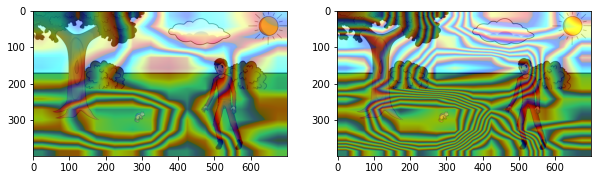

In [64]:
image_id = 70
question_id = 0
out_attention(image_id, question_id)